In [1]:
import numpy as np

import matplotlib.pyplot as plt


from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.interpolate import griddata


from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture


In [2]:
class FitGMM:
    '''
    Fits a random dataset to a Gaussian Mixture Model,
    extract and store its means, covariances, and weights. 
    
    '''
    def __init__(self, n_dimensions, n_components):
        '''
        Initializes parameters of the random dataset.
        
        Arguments
        n_dimensions [int]: number of dimensions of the input dataset
        n_components [int]: number of components in the input dataset
        
        '''
        self.n_dimensions = n_dimensions
        self.n_components = n_components
    
    def best_number_components(self, X):
        """
        Solve for the best number of components for GMM model based on BIC.

        Arguments
        X [np.array]: The input dataset.

        Returns
        self.n_components [int]: Best number of components.
        
        """
        n_components_range = range(1, 10) # set the number of components between 1 to 10
        bic = []
        for n in n_components_range:
            gmm = GaussianMixture(n_components = n)
            gmm.fit(X)
            bic.append(gmm.bic(X))
        self.n_components = n_components_range[np.argmin(bic)]
        print(f"Best number of components = {self.n_components}")
        
        return self.n_components

        
    def fit(self, X):
        '''
        Fits the input dataset into a Gaussian Mixture Model 
        and store the parameters means, covariances, and weights.
        
        Arguments
        X [np.array]: The input dataset to be fitted into a Gaussian Mixture Model
        
        Returns
        None
        
        '''
 
        best_n_components = self.best_number_components(X)
        gmm = GaussianMixture(n_components = best_n_components)
        gmm.fit(X)
        self.means = gmm.means_
        self.covariances = gmm.covariances_
        self.weights = gmm.weights_

In [3]:
class GaussianMixtureModel:
    def __init__(self, FitGMM):
        '''
        Initializes parameters of GaussianMixtureModel 
        using the parameters means, covariances, and weights
        which were stored in the FitGMM class.
        
        Arguments
        n_dimensions [int]: number of dimensions of the fitted dataset
        n_components [int]: number of components in the fitted dataset
        means [list]: means for each Gaussian component of the fitted dataset
        covs [list]: covariance matrices for each Gaussian component of the fitted dataset
        weights [list]: weights for each Gaussian component of the fitted dataset
        
        '''
        self.means = FitGMM.means
        self.covariances = FitGMM.covariances
        self.weights = FitGMM.weights
        self.n_components = FitGMM.n_components
        self.n_dimensions = FitGMM.n_dimensions

        
    def plot_scatter(self, X):
        '''
        Plots scatter plot for data.
        
        Arguments
        X [np.array]: dataset for which scatter plot will be plotted
        
        Returns
        None
                
        '''
        plt.rcParams["figure.figsize"] = (8, 6)
        
        n_dimensions = X.shape[1]
        
        # 2D data
        if n_dimensions == 2:
            plt.scatter(X[:, 0], X[:, 1], marker = 'o', s = 6, alpha = 0.5)
            plt.title("Scatter plot for Gaussian Mixture Model")
            plt.xlabel("$\mu1$")
            plt.ylabel("$\mu2$")
            plt.savefig('2Dscatter')
            plt.show()
        
        # 3D data
        elif n_dimensions == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection = '3d')
            ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker = 'o', s = 6, alpha = 0.5)
            plt.title("Scatter plot for Gaussian Mixture Model")
            ax.set_xlabel("$\mu1$")
            ax.set_ylabel("$\mu2$")
            ax.set_zlabel("$\mu3$")
            plt.savefig('3Dscatter')
            plt.show()
        
    def plot_histograms(self, X):
        '''
        Plots histograms for data.

        Arguments
        X [np.array]: dataset for which histograms will be plotted
        
        Returns
        None

        '''
        fig, axs = plt.subplots(X.shape[1], 1, figsize = (6, 3 * X.shape[1]), sharex = True, sharey = True)
        fig.suptitle("Histograms")

        for i in range(X.shape[1]):
            sns.distplot(X[:, i], ax = axs[i])
            axs[i].set_title("$\mu$" + str(i + 1))
            axs[i].set_ylabel("Frequency")
        plt.savefig('hist') 
        plt.show()
            

    def pdf(self, X):
        '''
        Calculates the probability density function (pdf) of the Gaussian Mixture Model 
        for a given set of samples in X.


            p(x_j|θ) is the probability density function at each independent sample with
            θ represents the parameters mean, covariance, and mixture coefficients,
            and x_1, x_2, ... , x_n are the observed samples in dataset X.


        Arguments
        X [np.array]: dataset for which pdf will be calculated

        Returns
        probs [np.array]: probabilities of the Gaussian Mixture Model for each sample in X

        '''
        prob = np.zeros((X.shape[0], self.n_components))
        
        for i in range(self.n_components):
            mean = self.means[i]
            cov = self.covariances[i]
            weight = self.weights[i]
            prob[:, i] = weight * multivariate_normal.pdf(X, mean, cov)
        
        probs = np.sum(prob, axis = 1) # sum probabilities of each component at each sample
        
        return probs
    
    def calculate_log_likelihoods(self, X):
        '''
        Calculates the log likelihood of the Gaussian Mixture Model for a given set of samples in X.


            The likelihood is calculated as the product of individual pdfs at the observed samples:

            L(θ) = p(x_1, x_2, ..., x_N|θ) = Π_j=1^N p(x_j|θ)

            Since likelihood of each point may be very small, leading to extremely small products, 
            a log likelihood is often used in practice:

            logL(θ) = Σ_j=1^N log(p(x_j|θ)) 

        
        Arguments
        X [np.array]: dataset for which log-likelihoods will be calculated

        Returns
        log_likelihoods [np.array]: log-likelihood of each sample in dataset X
        
        '''
        
        log_likelihoods = np.zeros(X.shape[0]) # initialize a numpy array of zeros to store log-likelihoods of each sample
        
        for i, x in enumerate(X):
            log_likelihood = 0 
            for j in range(self.n_components):
                # calculate log-likelihood of each sample by
                # adding product of mixture coefficient and pdf at sample x_j for each Gaussian component k
                log_likelihood += self.weights[j] * multivariate_normal.pdf(x, mean = self.means[j], cov = self.covariances[j])
            log_likelihoods[i] = np.log(log_likelihood) # store in log_likelihoods numpy array
        
        return log_likelihoods # return log-likelihood of each sample in dataset X
    
    def plot_log_likelihood(self, X, probs):
        '''
        Plots the log likelihood surface of data.

        Arguments
        X [np.array]: dataset for which scatterplot will be plotted
        probs [np.array]: probabilities of the Gaussian Mixture Model for each sample in X
        
        Returns
        None

        '''
        if self.n_dimensions == 2:
            fig = plt.figure(figsize = (8, 8), facecolor = "white")
            ax = fig.add_subplot(projection = "3d")
            
            x = X[:, 0]
            y = X[:, 1]
            z = probs
            
            # interpolate the points to make the plot smoother
            xi = np.linspace(min(x), max(x), 500)
            yi = np.linspace(min(y), max(y), 500)
            X, Y = np.meshgrid(xi, yi)
            Z = griddata((x, y), z, (X, Y), method = 'cubic')

            # plot the wireframe
            ax.plot_wireframe(X, Y, Z, rstride = 10, cstride = 10)
            
            # plot scatter plot
            ax.scatter(x, y, z, color = 'r',  marker = '.', alpha = 0.7)

            ax.set_xlabel("$\mu1$")
            ax.set_ylabel("$\mu2$")
            ax.set_zlabel("Log likelihood")
            ax.set_title("Log likelihood Plot")
            fig.tight_layout()
            plt.savefig('loglikelihood')
            fig.show()

In [4]:
### Test on 2D dataset

n_dimension = 2
n_sample = 2000
center = 6

# Generate a 2D dataset with n samples and initial number of centers
X, y = make_blobs(n_samples = n_sample, centers = center)

# Fit into a Gaussian Mixture Model
fit_gmm = FitGMM(n_dimensions = 2, n_components = center)

# Determine the best number of components
best_number_component = fit_gmm.best_number_components(X)


Best number of components = 4


Best number of components = 4


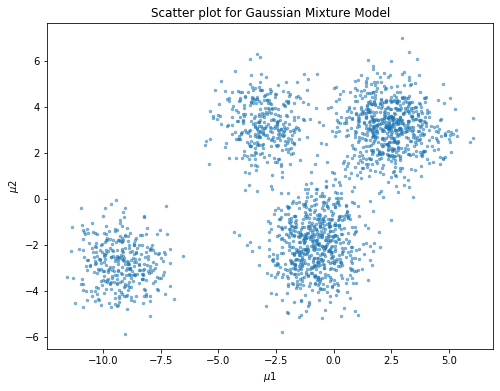

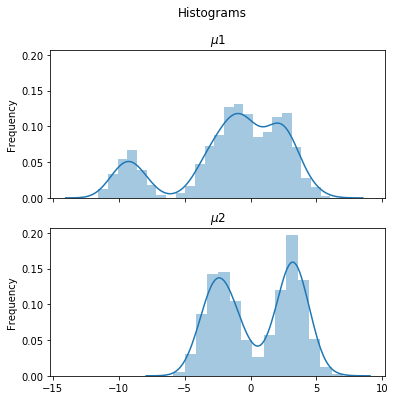

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


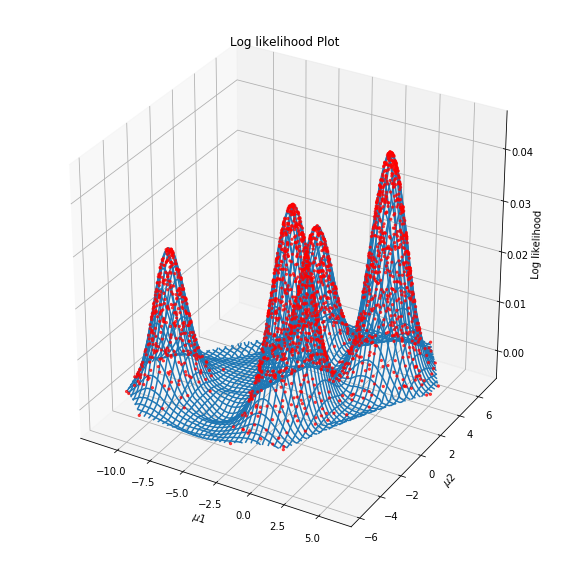

In [5]:
# Fit into a Gaussian Mixture Model with the calculated best number of components
fit_gmm = FitGMM(n_dimensions = n_dimension, n_components = best_number_component)
fit_gmm.fit(X)

# Create a GaussianMixtureModel with the fitted parameters
gmm = GaussianMixtureModel(fit_gmm)

# Visualize
gmm.plot_scatter(X)
gmm.plot_histograms(X)

# Calculate the probabilities of each sample in the input dataset
probs = gmm.pdf(X)

# Calculate the log-likelihoods of the input dataset
log_likelihood = gmm.calculate_log_likelihoods(X)
#print(log_likelihood)

# Plot the log-likelihoods of the input dataset
gmm.plot_log_likelihood(X, probs)
plt.show()


In [6]:
### Test on 3D dataset

n_dimension = 3
n_sample = 2000
center = 5

# Generate a 3D dataset with n samples and initial number of centers
X, y = make_blobs(n_samples = n_sample, n_features = n_dimension, centers = center)

# Fit into a Gaussian Mixture Model
fit_gmm = FitGMM(n_dimensions = n_dimension, n_components = center)

# Determine the best number of components
best_number_component = fit_gmm.best_number_components(X)


Best number of components = 5


Best number of components = 5


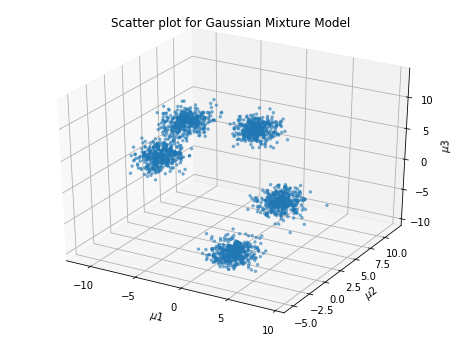

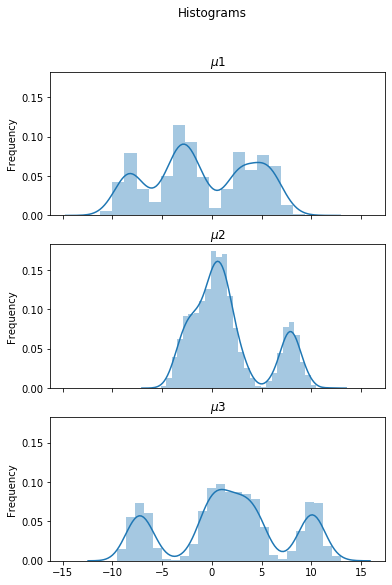

In [7]:
# Fit into a Gaussian Mixture Model with the calculated best number of components
fit_gmm = FitGMM(n_dimensions = n_dimension, n_components = best_number_component)
fit_gmm.fit(X)

# Create a GaussianMixtureModel with the fitted parameters
gmm = GaussianMixtureModel(fit_gmm)

# Visualize
gmm.plot_scatter(X)
gmm.plot_histograms(X)

# Calculate the probabilities of each sample in the input dataset
probs = gmm.pdf(X)

# Calculate the log-likelihoods of the input dataset
log_likelihood = gmm.calculate_log_likelihoods(X)
#print(log_likelihood)

# Plot the log-likelihoods of the input dataset
gmm.plot_log_likelihood(X, probs)
plt.show()
